In [37]:
from datascience import *
from datascience.predicates import are
import numpy as np
import math
from scipy import stats
from scipy import misc

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
# Function from Monday 6/6 Lec 2

def simulate_statistic(table, column_label, statistic, sample_size, repetitions):
    # assumes statistic(table, column_label, sample_size) returns
    # simulation of statistic based on one random sample
    return np.array([statistic(table, column_label, sample_size) for i in range(repetitions)])

In [5]:
# Function from Monday 6/6 Lec 2

def empirical_distribution(table, column_label, statistic, sample_size, repetitions):
    stats = simulate_statistic(table, column_label, statistic, sample_size, repetitions)
    Table().with_column('statistic', stats).hist()
    plots.xlabel('value of '+ statistic.__name__)
    plots.title('Empirical Histogram ('+str(repetitions)+' samples)')

In [60]:
# Function from Monday 6/6 Lec 2

def emp_dist_with_cutoffs(table, column_label, statistic, sample_size, repetitions):
    
    # Simulate the statistic and draw the histogram
    stats = simulate_statistic(table, column_label, statistic, sample_size, repetitions)
    Table().with_column('statistic', stats).hist()
    
    # Draw the right-hand-side 5% "rejection region"
    xmax = plots.xlim()[1]
    cutoff5 = np.sort(stats)[math.ceil(0.95*repetitions)]
    cutoff1 = np.sort(stats)[math.ceil(0.99*repetitions)]
    plots.plot([cutoff5, xmax], [0,0], color='yellow', lw=6)
    plots.plot([cutoff1, xmax], [0,0], color='red', lw=6)
    
    # Label the plot
    plots.xlabel('value of '+ statistic.__name__)
    plots.title('Empirical Histogram ('+str(repetitions)+' samples)')

In [23]:
def proportions_from_distribution(table, label, sample_size):
    proportions = np.random.multinomial(sample_size, table.column(label))/sample_size
    return table.with_column('Random Sample', proportions)

### An ACLU report

[Racial and Ethnic Disparities](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf)

In [6]:
# The data

jury = Table(["Race", "Eligible", "Panel"]).with_rows([
    ["Asian",  0.15, 0.26],
    ["Black",  0.18, 0.08],
    ["Latino", 0.12, 0.08],
    ["White",  0.54, 0.54],
    ["Other",  0.01, 0.04],
    ])
jury

Race,Eligible,Panel
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


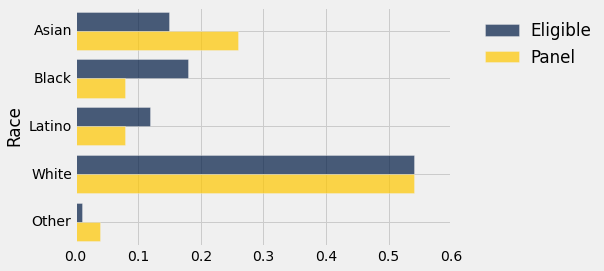

In [6]:
jury.barh('Race')

In [10]:
# Augment the table with a column of differences between proportions

jury_diffs = jury.with_column(
    'Difference', jury.column('Panel') - jury.column('Eligible')
)
jury_diffs

Race,Eligible,Panel,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


In [11]:
# Add all the positive differences

jury_diffs.select('Difference').where('Difference', are.above(0)).sum()

Difference
0.14


In [12]:
# Add all the negative differences

jury_diffs.select('Difference').where('Difference', are.below(0)).sum()

Difference
-0.14


In [13]:
# Extract the differences as an array,
# drop the signs and add all of them,
# then divide by 2.

sum(abs(jury_diffs.column('Difference')))/2

0.14000000000000001

In [14]:
# total variation distance

def tvd(table, column_a, column_b):
    return sum(abs(table.column(column_a) - table.column(column_b)))/2

In [15]:
tvd(jury, 'Eligible', 'Panel')

0.14000000000000001

In [18]:
# The number of people on the panels
# This is known and hence fixed.

panel_size = 1453

In [24]:
# Augment the jury table with a column that contains
# proportions from a sample drawn at random from the Eligible distribution.

panel_and_sample = proportions_from_distribution(jury, 'Eligible', panel_size)
panel_and_sample

Race,Eligible,Panel,Random Sample
Asian,0.15,0.26,0.152099
Black,0.18,0.08,0.158293
Latino,0.12,0.08,0.128011
White,0.54,0.54,0.551273
Other,0.01,0.04,0.0103235


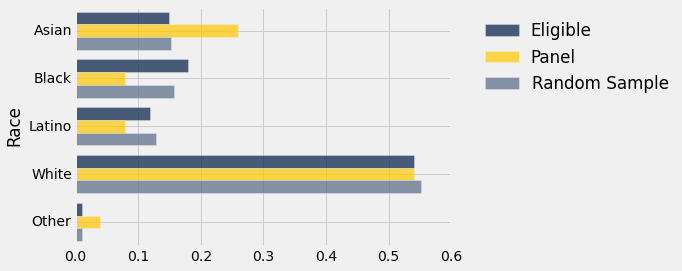

In [25]:
panel_and_sample.barh('Race')

In [26]:
tvd(panel_and_sample, 'Eligible', 'Random Sample')

0.021706813489332406

In [29]:
# Total variation distance between distribution in table.column(label)
# and the distribution of a random sample of size sample_size
# drawn from that column

def random_sample_tvd(table, label, sample_size):
    t_sample = proportions_from_distribution(table, label, sample_size)
    return tvd(t_sample, label, 'Random Sample')  

In [31]:
random_sample_tvd(jury, 'Eligible', panel_size)

0.0075223675154852312

In [32]:
# Simulate the tvd 10 times

simulate_statistic(jury, 'Eligible', random_sample_tvd, panel_size, 10)

array([ 0.01794219,  0.0298073 ,  0.01415692,  0.00786648,  0.00993118,
        0.02057811,  0.00931865,  0.00419821,  0.01604267,  0.00984859])

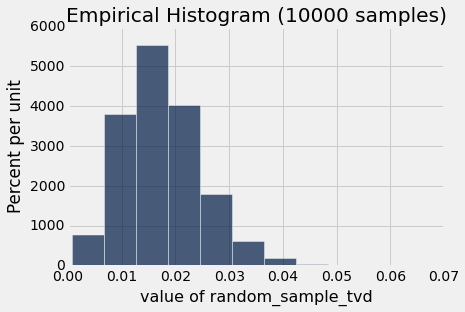

In [64]:
# Simulate the tvd lots of times and draw the empirical histogram

empirical_distribution(jury, 'Eligible', random_sample_tvd, panel_size, 10000)

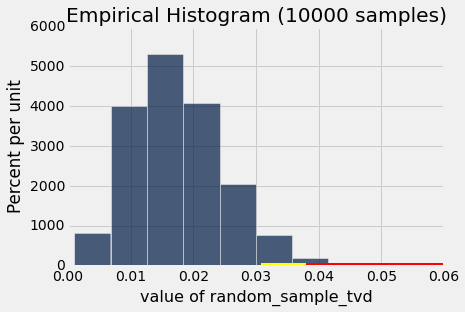

In [65]:
emp_dist_with_cutoffs(jury, 'Eligible', random_sample_tvd, panel_size, 10000)